# Buoyant Cavity (2D)
This notebook implements a steady incompressible Navier-Stokes solver + energy equation for the buoyant cavity problem.

The problem is strong form reads:
\begin{equation}
\left\{
\begin{array}{ll}
    \nabla \cdot \mathbf{u} =0& in\;\Omega\\
    \displaystyle \left(\mathbf{u}\cdot \nabla\right)\mathbf{u}= \nu\Delta \mathbf{u}-\nabla p & in\;\Omega\\ 
    \mathbf{u}\cdot \nabla T = \alpha \Delta T& in\;\Omega\\& \\
    \mathbf{u} = \mathbf{j},\; T=T_H & on\;\Gamma_{hot}\\
    \mathbf{u} = \mathbf{j},\; T=T_C & on\;\Gamma_{cold}\\
    \mathbf{u} = \mathbf{0},\;\frac{\partial T}{\partial \mathbf{n}}=0 & on\;\Gamma_w
\end{array}
\right.
\end{equation}

In [1]:
import tqdm
import numpy as np

# Mesh generation
import dolfinx
from mpi4py import MPI
from dolfinx import mesh
from dolfinx.io import gmshio, XDMFFile
from dolfinx import fem
from dolfinx.fem import (Function, FunctionSpace, dirichletbc, locate_dofs_topological, 
                         form, assemble_scalar, locate_dofs_geometrical)
import ufl
from ufl import grad, div, nabla_grad, dx, inner, dot
from petsc4py import PETSc
from dolfinx.mesh import (CellType, GhostMode, create_rectangle, locate_entities_boundary)

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

The problem we want to face is non-linear, whose weak formulation reads:
\begin{equation}
\int_\Omega \left(\mathbf{u}\cdot \nabla\right)\mathbf{u}\cdot \mathbf{v}\,d\Omega + \nu \int_\Omega\nabla \mathbf{u}\cdot \nabla \mathbf{v}\,d\Omega -\int_\Omega p(\nabla\cdot\mathbf{v})\,d\Omega -\int_\Omega q(\nabla\cdot\mathbf{u})\,d\Omega - \beta\int_\Omega(T-T_{ref})\mathbf{g}\cdot \mathbf{v}\,d\Omega + \int_\Omega \mathbf{u}\cdot \nabla T \, \phi\,d\Omega+\int_\Omega \alpha\nabla T \cdot \nabla\phi\,d\Omega=0
\end{equation}

In [10]:
# Function to mark x = 0
def hot(x):
    return np.isclose(x[0], 0.0)
# Function to mark x = 1
def cold(x):
    return np.isclose(x[0], 1.0)
# Function to mark y = 0,1
def noslip_boundary(x):
    return np.logical_or(np.isclose(x[1], 0.0),
                         np.isclose(x[1], 1.0))

# Lid velocity
def lid_velocity_expression(x):
    return np.stack((np.zeros(x.shape[1]), np.ones(x.shape[1])))

class buoyant_cavity_NS():
    def __init__(self, N):

        # Domain
        self.domain = create_rectangle(MPI.COMM_WORLD,[np.array([0, 0]), np.array([1, 1])], [N, N], CellType.triangle, GhostMode.none)
        self.gdim = self.domain.geometry.dim
        self.fdim = self.gdim - 1

        # Functional Spaces
        self.P2 = ufl.VectorElement("Lagrange", self.domain.ufl_cell(), 2)
        self.P1 = ufl.FiniteElement("Lagrange", self.domain.ufl_cell(), 1)
        self.mixEl = ufl.MixedElement(self.P2, self.P1, self.P1)
        self.W = FunctionSpace(self.domain, self.mixEl)

        # Test and trial functions: monolithic
        (self.v, self.q, self.phi) = ufl.TestFunctions(self.W)
        self.dupT = ufl.TrialFunction(self.W)
        self.upT  = fem.Function(self.W)
        (self.u, self.p, self.T) = ufl.split(self.upT)

    def parameters(self, Re, Ri, TH, TC, Pr = 0.71):

        # Computing the viscosity
        self.nuValue = 1. / Re
        print('Re = {:.0f}'.format(Re)+' and nu = {:.2e}'.format(self.nuValue)+' [m2/s]')
        self.alphaValue = self.nuValue / Pr
        print('Pr = {:.0f}'.format(Pr)+' and alpha = {:.2e}'.format(self.alphaValue)+' [m2/s]')
        beta = Ri / ( 9.81 * (TH-TC) )
        print('Ri = {:.0f}'.format(Ri)+' and beta = {:.2e}'.format(beta)+' [1/K]')

        self.nu = fem.Constant(self.domain, PETSc.ScalarType(self.nuValue))
        self.alpha = fem.Constant(self.domain, PETSc.ScalarType(self.alphaValue))
        self.beta = fem.Constant(self.domain, PETSc.ScalarType(beta))

        self.gravity = fem.Constant(self.domain, (PETSc.ScalarType(0.), PETSc.ScalarType(-9.81)))
        self.Tref = fem.Constant(self.domain, PETSc.ScalarType(TC))

        # Setting Boundary Conditions
        self.lid_velocity = Function(self.W.sub(0).collapse()[0])
        self.lid_velocity.interpolate(lid_velocity_expression)
        self.ft_hot = locate_entities_boundary(self.domain, self.fdim, hot)
        self.dofs_hot_u = locate_dofs_topological((self.W.sub(0), self.W.sub(0).collapse()[0]), self.fdim, self.ft_hot)
        self.bc_hot_u = dirichletbc(self.lid_velocity, self.dofs_hot_u, self.W.sub(0))
        self.dofs_hot_T = locate_dofs_topological((self.W.sub(2), self.W.sub(2).collapse()[0]), self.fdim, self.ft_hot)
        self.T_hot = Function(self.W.sub(2).collapse()[0])
        self.T_hot.x.set(TH)
        self.bc_hot_T = dirichletbc(self.T_hot, self.dofs_hot_T, self.W.sub(2))

        self.ft_cold = locate_entities_boundary(self.domain, self.fdim, cold)
        self.dofs_cold_u = locate_dofs_topological((self.W.sub(0), self.W.sub(0).collapse()[0]), self.fdim, self.ft_cold)
        self.bc_cold_u = dirichletbc(self.lid_velocity, self.dofs_cold_u, self.W.sub(0))
        self.dofs_cold_T = locate_dofs_topological((self.W.sub(2), self.W.sub(2).collapse()[0]), self.fdim, self.ft_cold)
        self.T_cold = Function(self.W.sub(2).collapse()[0])
        self.T_cold.x.set(TC)
        self.bc_cold_T = dirichletbc(self.T_cold, self.dofs_cold_T, self.W.sub(2))

        self.no_slip  = Function(self.W.sub(0).collapse()[0])
        self.ft_walls = locate_entities_boundary(self.domain, self.fdim, noslip_boundary)
        self.dofs_walls = locate_dofs_topological((self.W.sub(0), self.W.sub(0).collapse()[0]), self.fdim, self.ft_walls)
        self.bc_w = dirichletbc(self.no_slip, self.dofs_walls, self.W.sub(0))

        self.zero_p = Function(self.W.sub(1).collapse()[0])
        self.zero_p.x.set(0.0)
        self.dofs_p = locate_dofs_geometrical((self.W.sub(1), self.W.sub(1).collapse()[0]), 
                                              lambda x: np.isclose(x.T, [0, 0, 0]).all(axis=1))
        self.bc_p = dirichletbc(self.zero_p, self.dofs_p, self.W.sub(1))

        self.bcs = [self.bc_hot_u, self.bc_hot_T, self.bc_cold_u, self.bc_cold_T, self.bc_w, self.bc_p]

    def create_snes_solution(self) -> PETSc.Vec:  # type: ignore[no-any-unimported]
        """
        Create a petsc4py.PETSc.Vec to be passed to petsc4py.PETSc.SNES.solve.

        The returned vector will be initialized with the initial guess provided in `self._solution`.
        """
        x = self._solution.vector.copy()
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _x[:] = _solution
        return x

    def update_solution(self, x: PETSc.Vec) -> None:  # type: ignore[no-any-unimported]
        """Update `self._solution` with data in `x`."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _solution[:] = _x
            
    def obj_fun(self, snes: PETSc.SNES, x: PETSc.Vec) -> np.float64:
            """Compute the norm of the residual."""
            self.F_fun(snes, x, self._obj_vec)
            return self.b.norm()  # type: ignore[no-any-return]

    def F_fun(self, snes: PETSc.SNES, x: PETSc.Vec, F_vec: PETSc.Vec) -> None:
            """Assemble the residual."""
            self.update_solution(x)
            with F_vec.localForm() as F_vec_local:
                F_vec_local.set(0.0)
            fem.petsc.assemble_vector(F_vec, self._F)
            dolfinx.fem.apply_lifting(F_vec, [self._J], [self.bcs], x0=[x], scale=-1.0)
            F_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
            fem.set_bc(F_vec, self.bcs, x, -1.0)

    def J_fun( self, snes: PETSc.SNES, x: PETSc.Vec, J_mat: PETSc.Mat, P_mat: PETSc.Mat) -> None:
            """Assemble the jacobian."""
            J_mat.zeroEntries()
            fem.petsc.assemble_matrix(J_mat, self._J, self.bcs, diagonal=1.0)
            J_mat.assemble()

    def assemble(self, maxIter):

        # Variational forms
        ## Continuity
        self.F  = inner(div(self.u), self.q) * ufl.dx 
        ## Momentum
        self.F += (self.nu * inner(grad(self.u), grad(self.v)) * ufl.dx + 
                   inner(grad(self.u) * self.u, self.v) * ufl.dx -
                   inner(self.p, ufl.div(self.v)) * ufl.dx +
                   self.beta * (self.T - self.Tref) * dot(self.gravity, self.v) * ufl.dx)
        ## Energy
        self.F += (inner(self.u, grad(self.T)) * self.phi * ufl.dx +
                   inner(self.alpha * grad(self.T), grad(self.phi)) * ufl.dx)
                  
        self.J = ufl.derivative(self.F, self.upT, self.dupT)

        self._F = form(self.F)
        self._J = form(self.J)

        # Create matrix and vector
        self._solution = self.upT
        self._obj_vec = fem.petsc.create_vector(self._F)
        self.b = fem.petsc.create_vector(self._F)
        self.A = fem.petsc.create_matrix(self._J)

        # Solver settings
        self.solver = PETSc.SNES().create(self.domain.comm)
        self.solver.setTolerances(max_it=maxIter)
        self.solver.getKSP().setType("preonly")
        self.solver.getKSP().getPC().setType("lu")
        self.solver.getKSP().getPC().setFactorSolverType("mumps")

        self.solver.setObjective(self.obj_fun)
        self.solver.setFunction(self.F_fun, self.b)
        self.solver.setJacobian(self.J_fun, J=self.A, P=None)
        self.solver.setMonitor(lambda _, it, residual: print(it, residual))

    def solve(self):
        upT_copy = self.create_snes_solution()
        self.solver.solve(None, upT_copy)
        self.update_solution(upT_copy)
        return self._solution

In [11]:
N = 64

TH = 320.
TC = 300.
Re = 150.
Ri = 2.

cavity = buoyant_cavity_NS(N)
cavity.parameters(Re, Ri, TH, TC)
cavity.assemble(20)
upT_sol = cavity.solve()
(u_sol, p_sol, T_sol) = (upT_sol.sub(0).collapse(), upT_sol.sub(1).collapse(), upT_sol.sub(2).collapse())

Re = 150 and nu = 6.67e-03 [m2/s]
Pr = 1 and alpha = 9.39e-03 [m2/s]
Ri = 2 and beta = 1.02e-02 [1/K]
0 3536.570548584404
1 0.18003842168825648
2 0.060906347113540954
3 0.022582487672829263
4 0.006795033701058301
5 0.0012571159339550607
6 2.0879274712398992e-05


The following function is used to extract the values of the velocity and temperature functions.

In [12]:
def extract2D_vec(problem, N, u_sol):
    grid = np.linspace(0, 1, N)
    ux = np.zeros((N,N))
    uy = np.zeros((N,N))

    for ii in range(N):
        points = np.zeros((3, N))
        points[0, :] = grid[ii]
        points[1, :] = grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(problem.domain, problem.domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(problem.domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        ux[ii, :] = u_sol.sub(0).eval(xPlot, cells).flatten()
        uy[ii, :] = u_sol.sub(1).eval(xPlot, cells).flatten()
    return ux.T, uy.T, grid

def extract2D_scalar(problem, N, T_sol):
    grid = np.linspace(0, 1, N)
    T = np.zeros((N,N))

    for ii in range(N):
        points = np.zeros((3, N))
        points[0, :] = grid[ii]
        points[1, :] = grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(problem.domain, problem.domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(problem.domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        T[ii, :] = T_sol.eval(xPlot, cells).flatten()
    return T.T, grid

Let's plot the solution

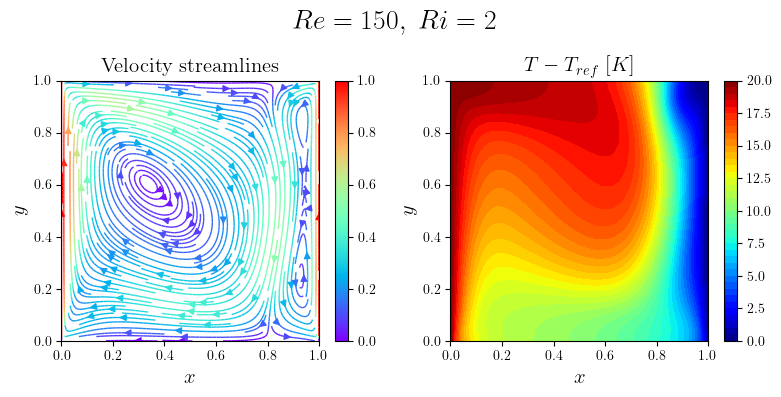

In [18]:
fig = plt.figure(figsize = (8,4))

ux, uy, grid = extract2D_vec(cavity, N, u_sol)
T, grid = extract2D_scalar(cavity, N, T_sol)

X, Y = np.meshgrid(grid, grid)

plt.subplot(1,2,1)
plt.streamplot(X, Y, ux, uy, color=np.sqrt(ux**2+uy**2), linewidth=1, cmap='rainbow', density=2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.clim(0,1)
plt.colorbar()
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$y$', fontsize = 15)
plt.title(r'Velocity streamlines', fontsize = 15)

plt.subplot(1,2,2)
plt.contourf(X, Y, T-TC, cmap='jet', levels = 40)
plt.clim(0.,TH-TC)
plt.colorbar()
plt.xlabel(r'$x$', fontsize = 15)
plt.ylabel(r'$y$', fontsize = 15)
plt.title(r'$T-T_{ref}\; [K]$', fontsize = 15)

plt.suptitle(r'$Re = {:.0f}'.format(Re)+',\;Ri = {:.0f}'.format(Ri)+'$', fontsize = 20)
plt.tight_layout()